# 🌍 Seismic Imaging Course – 2025 Edition
### Numerical Modeling & Inversion (1/3)
**Professor:** Nicola Bienati

**Author:** Felipe Rincón  
*PhD Student in Geophysics*  
📧 felipe.rincon@phd.unipi.it  

/var/folders/s2/qbbddkw9511125_hf1dl0zd40000gn/T/ipykernel_15392/1152811897.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


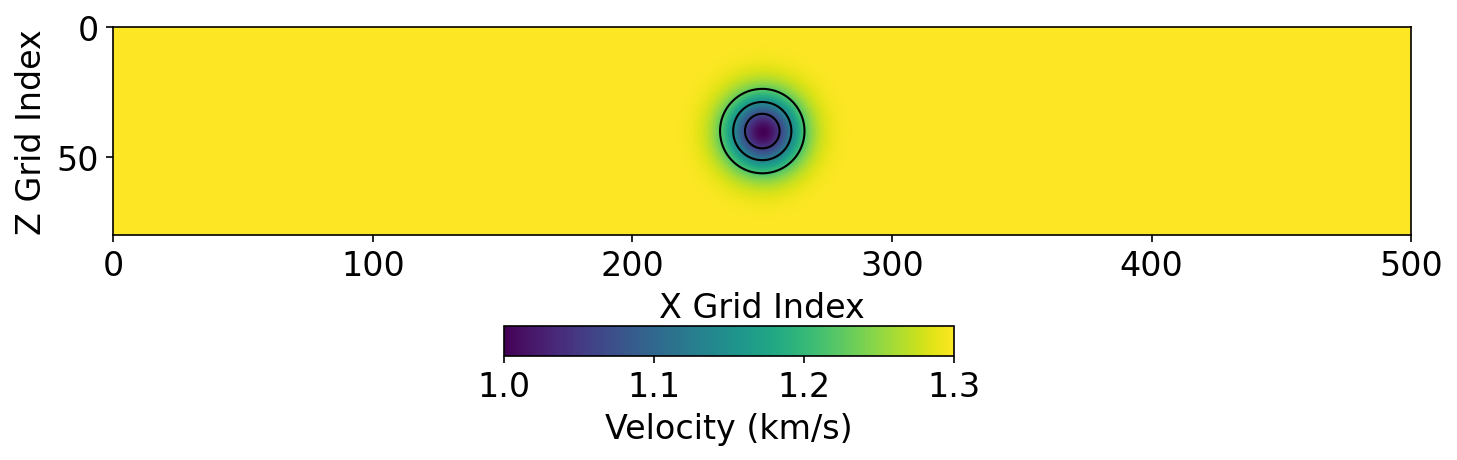

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from seismic_utils import (
    generate_source_locations,
    generate_receiver_coordinates,
    plot_shotrecord2,
    compute_residual,
    fwi_gradient,
    plot_velocity_clim,
    Model,
    configuration,
    AcquisitionGeometry,
    AcousticWaveSolver,
    mmax,
    compute_update
)

# Define model parameters
nx, nz = 500, 80
v0 = 1.3  # Background velocity
velocity = np.full((nz, nx), v0, dtype=float)

# Gaussian anomaly parameters
cx, cz = nx // 2, nz // 2  # Center of anomaly
sigma = 10                 # Controls spread of the Gaussian
perturbation = 0.3         # Amplitude of velocity reduction

# Generate coordinate grids
x = np.arange(nx)
z = np.arange(nz)
X, Z = np.meshgrid(x, z)

gaussian = perturbation * np.exp(-((X - cx)**2 + (Z - cz)**2) / (2 * sigma**2))
velocity -= gaussian

# Plotting
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(velocity, cmap="viridis", origin="lower", extent=[0, nx, 0, nz])
ax.invert_yaxis()
ax.set_xlabel("X Grid Index")
ax.set_ylabel("Z Grid Index")

# Optional: overlay a contour to visualize the anomaly boundary
cs = ax.contour(X, Z, gaussian, levels=3, colors='black', linewidths=1)

# Colorbar
cbar_ax = fig.add_axes([0.35, 0.2, 0.3, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Velocity (km/s)")
plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()

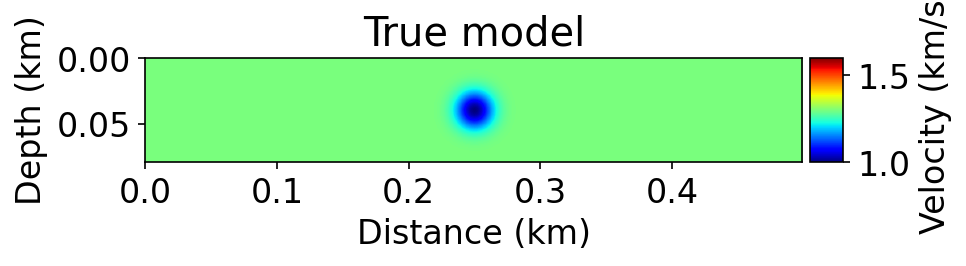

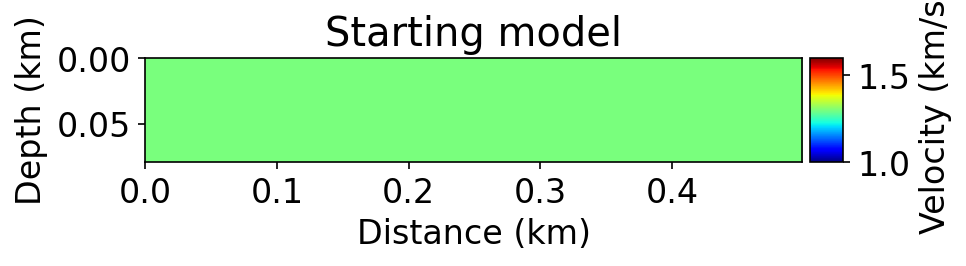

In [25]:
configuration['log-level'] = 'WARNING'
nshots = 1  # Number of shots
nreceivers = 1  # Number of receivers
fwi_iterations = 1  # Number of iterations

# Define true and initial model
shape = (500, 80)  # Number of grid point (nx, nz)
spacing = (1, 1) #in meters
origin = (0., 0.) 

v=np.transpose(velocity)
nbl=20
true_model = Model(vp=v, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
plot_velocity_clim(true_model, vmin=v0-perturbation, vmax=v0+perturbation, name="True model", cmap="jet")

#create an starting model
v2=np.ones(shape)*v0
start_model = Model(vp=v2, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
plot_velocity_clim(start_model, vmin=v0-perturbation, vmax=v0+perturbation, name="Starting model", cmap="jet")

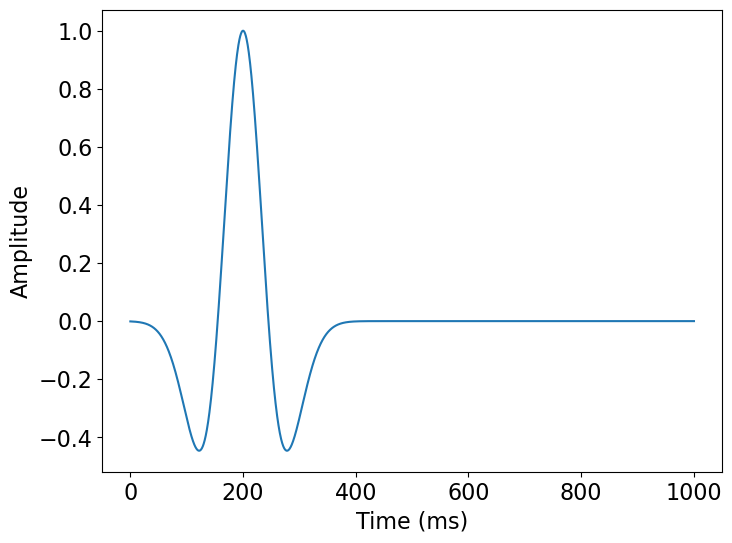

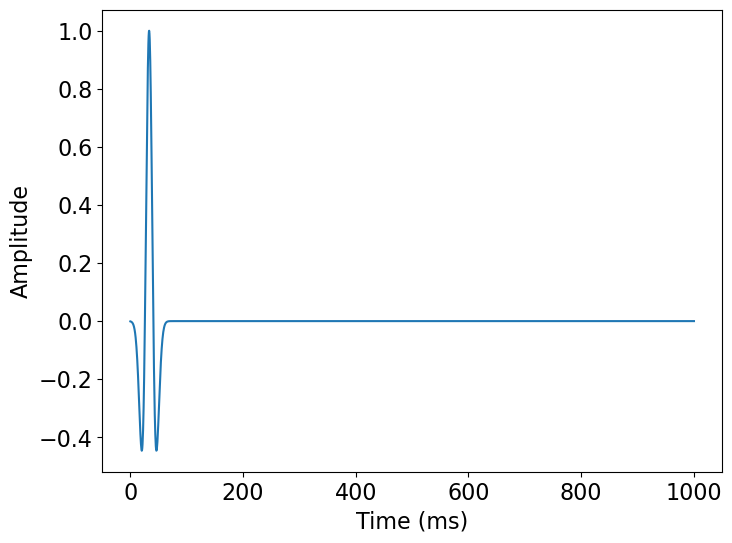

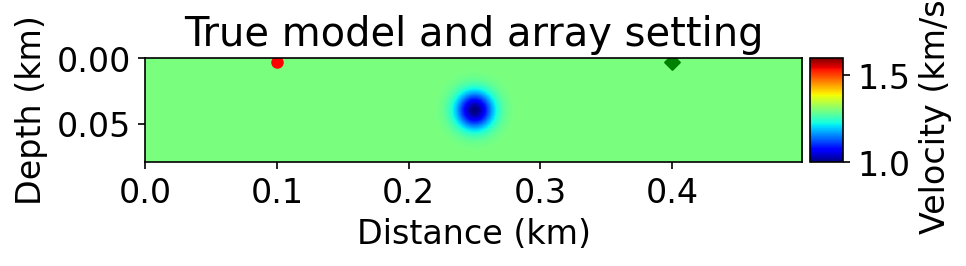

In [26]:
# Define acquisition geometry
t0 = 0
time = 1000.0
dt1 = 0.005 #KHz which means 5 Hz
dt2 = 0.03 #KHz which means 10 Hz

src_coordinates = np.empty((1, 2))
src_coordinates[0, 0] = 100
src_coordinates[0, -1] = 3

rec_coordinates = np.empty((1, 2))
rec_coordinates[:, 0] = 400
rec_coordinates[:, -1] = 3

geometry1 = AcquisitionGeometry(true_model, rec_coordinates, src_coordinates, t0, tn=time, f0=dt1, src_type='Ricker')
geometry1.src.show()

geometry2 = AcquisitionGeometry(true_model, rec_coordinates, src_coordinates, t0, tn=time, f0=dt2, src_type='Ricker')
geometry2.src.show()

plot_velocity_clim(true_model,vmin=v0-perturbation, vmax=v0+perturbation, name="True model and array setting", cmap="jet", source=geometry1.src_positions,receiver=geometry1.rec_positions[::4, :])

In [27]:
# simulate the low and high frequency true and initial data
solver1 = AcousticWaveSolver(true_model, geometry1, space_order=4)
true_data1, _, _ = solver1.forward(vp=true_model.vp)
initial_data1, _, _ = solver1.forward(vp=start_model.vp)

solver2 = AcousticWaveSolver(true_model, geometry2, space_order=4)
true_data2, _, _ = solver2.forward(vp=true_model.vp)
initial_data2, _, _ = solver2.forward(vp=start_model.vp)

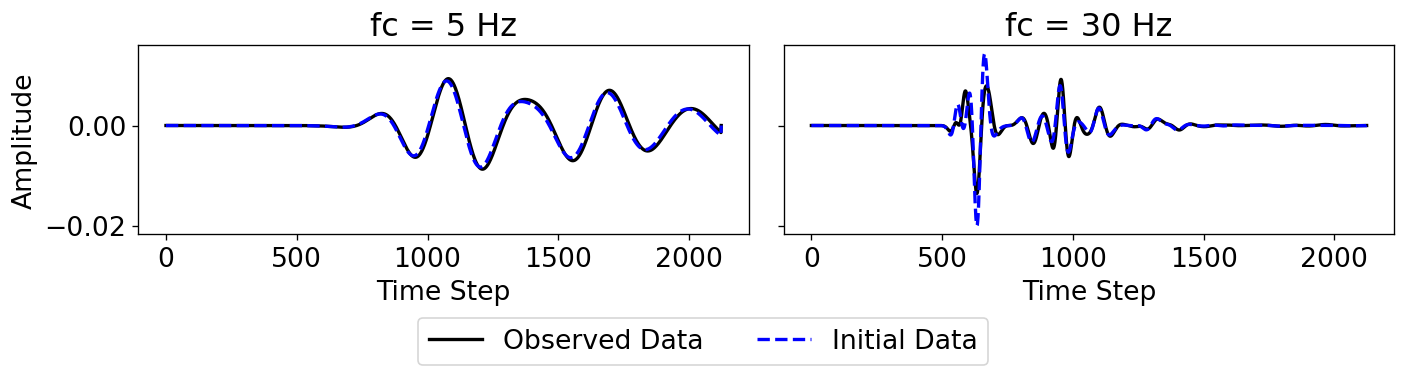

In [ ]:
# check the simulations
fc1 = dt1*1000
fc2 = dt2*1000

fig, axs = plt.subplots(1, 2, figsize=(12, 3), dpi=120, sharey=True)

# First subplot
axs[0].plot(true_data1.data, label='Observed Data', color='black', linewidth=2, linestyle='-')
axs[0].plot(initial_data1.data, label='Initial Data', color='blue', linewidth=2, linestyle='--')
axs[0].set_title(f'fc = {fc1:.0f} Hz')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Amplitude')

# Second subplot
axs[1].plot(true_data2.data, color='black', linewidth=2, linestyle='-')
axs[1].plot(initial_data2.data, color='blue', linewidth=2, linestyle='--')
axs[1].set_title(f'fc = {fc2:.0f} Hz')
axs[1].set_xlabel('Time Step')
axs[1].tick_params(labelleft=False)  # Hide y-axis numbers on second plot

# Add a single horizontal legend below the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Make space for legend
# plt.savefig("init_obs_data.pdf", format='pdf', dpi=300)
plt.show()

In [29]:
# Setup
case_src = 1
mult = len(str(case_src))

# Run for both geometries
ff1, a1, b1, c1 = compute_update(geometry1, solver1, start_model, true_model, src_coordinates, nshots, shape, nbl, mult)
ff2, a2, b2, c2 = compute_update(geometry2, solver2, start_model, true_model, src_coordinates, nshots, shape, nbl, mult)

/var/folders/s2/qbbddkw9511125_hf1dl0zd40000gn/T/ipykernel_15392/893858798.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


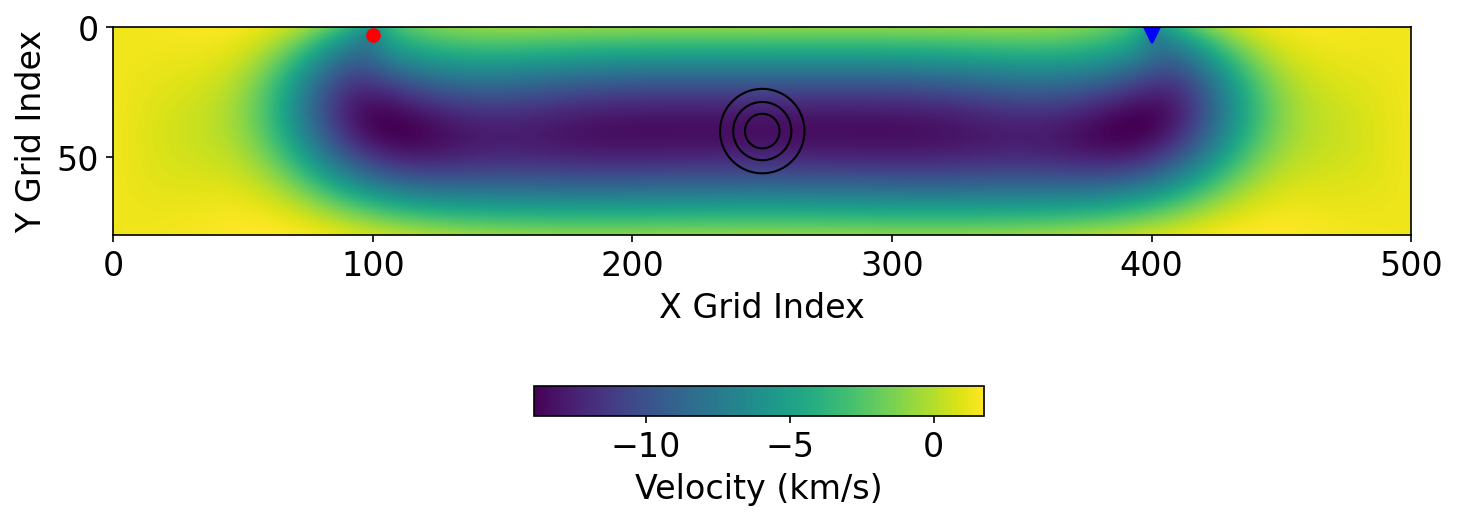

In [ ]:
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(c1), cmap="viridis", origin="lower", extent=[0, nx, 0, nz])

ax.plot(100, 3, 'ro', markersize=6, label="Source")
ax.plot(400, 3, marker='v', color='blue', markersize=8, label="Receiver")

ax.invert_yaxis()
ax.set_xlabel("X Grid Index")
ax.set_ylabel("Y Grid Index")
cs = ax.contour(X, Z, gaussian, levels=3, colors='black', linewidths=1)

cbar_ax = fig.add_axes([0.37, 0.1, 0.3, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Velocity (km/s)")
plt.tight_layout(rect=[0, 0.15, 1, 1])
# plt.savefig("kernel5Hz.pdf", format='pdf', dpi=300)

/var/folders/s2/qbbddkw9511125_hf1dl0zd40000gn/T/ipykernel_15392/1044820591.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


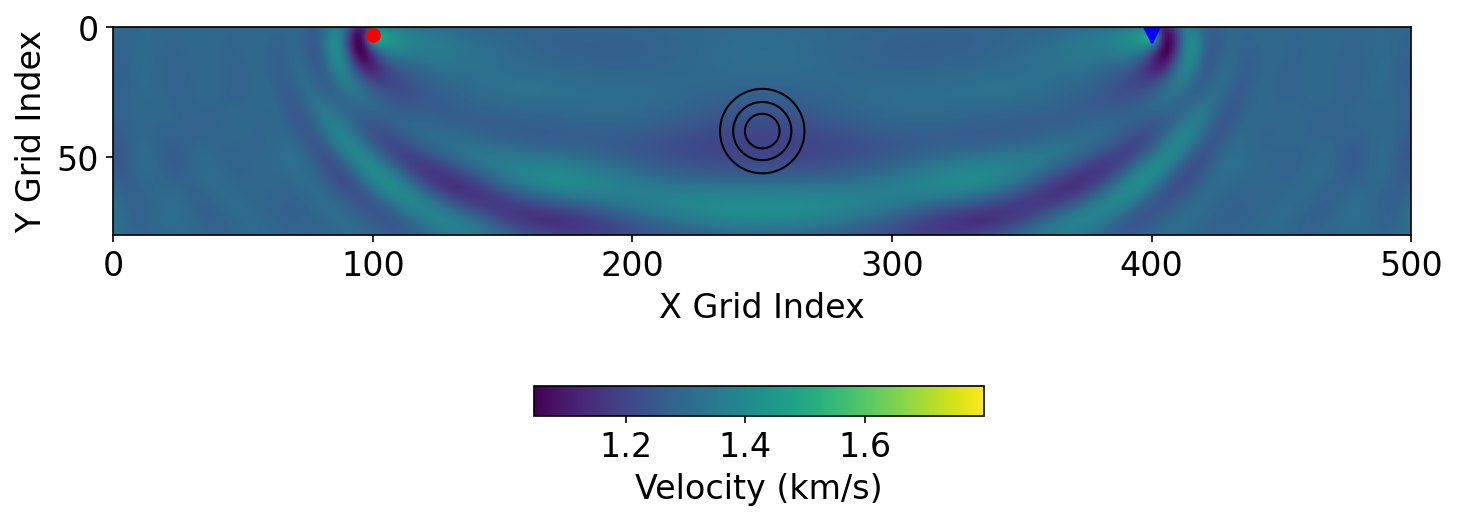

In [ ]:
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(c2), cmap="viridis", origin="lower", extent=[0, nx, 0, nz])

ax.plot(100, 3, 'ro', markersize=6, label="Source")
ax.plot(400, 3, marker='v', color='blue', markersize=8, label="Receiver")

ax.invert_yaxis()
ax.set_xlabel("X Grid Index")
ax.set_ylabel("Y Grid Index")
cs = ax.contour(X, Z, gaussian, levels=3, colors='black', linewidths=1)

cbar_ax = fig.add_axes([0.37, 0.1, 0.3, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Velocity (km/s)")
plt.tight_layout(rect=[0, 0.15, 1, 1])
# plt.savefig("kernel30Hz", format='pdf', dpi=300)

/var/folders/s2/qbbddkw9511125_hf1dl0zd40000gn/T/ipykernel_15392/545816013.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


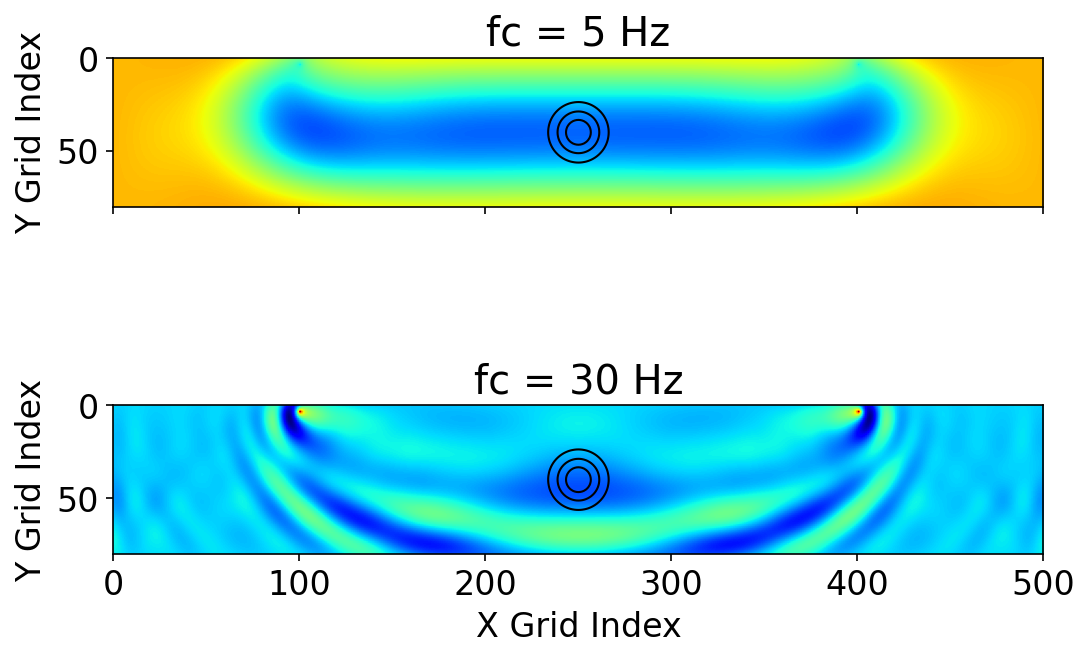

In [33]:
vmin = min(np.min(c1), np.min(c2))
vmax = max(np.max(c1), np.max(c2))

vmin = -20
vmax = 10

# Plot the sensitivity kernels
fig, axs = plt.subplots(2, 1, figsize=(8, 6), dpi=150, sharex=True,
                        gridspec_kw={'hspace': 0.005})  # very tight vertical space

im1 = axs[0].imshow(np.transpose(c1), cmap="jet", origin="lower",
                    extent=[0, nx, 0, nz], vmin=vmin, vmax=vmax)
axs[0].invert_yaxis()
cs = axs[0].contour(X, Z, gaussian, levels=3, colors='black', linewidths=1)

axs[0].set_title(f'fc = {fc1:.0f} Hz')
axs[0].set_ylabel("Y Grid Index")
axs[0].tick_params(labelbottom=False)  # Hide x labels and ticks

im2 = axs[1].imshow(np.transpose(c2), cmap="jet", origin="lower",
                    extent=[0, nx, 0, nz])
axs[1].invert_yaxis()
cs = axs[1].contour(X, Z, gaussian, levels=3, colors='black', linewidths=1)

axs[1].set_title(f'fc = {fc2:.0f} Hz')
axs[1].set_xlabel("X Grid Index")
axs[1].set_ylabel("Y Grid Index")

plt.tight_layout()
plt.show()